In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Cargar los 16 conjuntos de datos
dataset1 = pd.read_csv('Q22019.csv')
dataset2 = pd.read_csv('Q12018.csv')
dataset3 = pd.read_csv('Divvy_Trips_2018_Q2.csv')
dataset4 = pd.read_csv('Divvy_Trips_2018_Q3.csv')
dataset5 = pd.read_csv('Divvy_Trips_2018_Q4.csv')
dataset6 = pd.read_csv('Divvy_Trips_2019_Q1.csv')
dataset7 = pd.read_csv('Divvy_Trips_2019_Q3.csv')
dataset8 = pd.read_csv('Divvy_Trips_2019_Q4.csv')


# Concatenar los conjuntos de datos
data = pd.concat([dataset1, dataset2,dataset3,dataset4,dataset5,dataset6,dataset7,dataset8])

In [3]:
data.shape

(7421086, 12)

In [4]:
data.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear'],
      dtype='object')

In [5]:
# Eliminar columnas no hacen falta
columnas_a_eliminar = ['trip_id', 'end_time','bikeid', 'from_station_id', 'to_station_id','gender', 'birthyear', 'tripduration','usertype','to_station_name']
data = data.drop(columnas_a_eliminar, axis=1)

In [6]:
data.head()

,start_time,from_station_name
0,2019-04-01 00:02:22,Daley Center Plaza
1,2019-04-01 00:03:02,Wood St & Taylor St
2,2019-04-01 00:11:07,LaSalle St & Jackson Blvd
3,2019-04-01 00:13:01,McClurg Ct & Illinois St
4,2019-04-01 00:19:26,Halsted St & 18th St


# MEJOR ESTACIONES DE SUSCRIPTORES

In [7]:
#Elegir la estación deseada
estacion_elegida = 'Clinton St & Washington Blvd'  # Reemplaza 'Nombre de la estación' por el nombre real de la estación.

#Filtrar los datos para la estación deseada.
data_estacion_elegida = data[data['from_station_name'] == estacion_elegida].copy()

In [8]:
data_estacion_elegida.head()

,start_time,from_station_name
31,2019-04-01 04:11:03,Clinton St & Washington Blvd
156,2019-04-01 06:08:45,Clinton St & Washington Blvd
157,2019-04-01 06:08:45,Clinton St & Washington Blvd
183,2019-04-01 06:16:07,Clinton St & Washington Blvd
184,2019-04-01 06:16:25,Clinton St & Washington Blvd


In [9]:
#Convertir la columna 'start_time' en formato datetime y establecerla como índice.
data_estacion_elegida['start_time'] = pd.to_datetime(data_estacion_elegida['start_time'])
data_estacion_elegida.set_index('start_time', inplace=True)

In [10]:
#Agrupar por día y contar la frecuencia de registros.
frecuencia_por_dia = data_estacion_elegida.resample('D').size()
frecuencia_por_dia

start_time
2018-01-02    53
2018-01-03    90
2018-01-04    75
2018-01-05    70
2018-01-06     1
              ..
2019-12-27    61
2019-12-28     5
2019-12-29     5
2019-12-30    55
2019-12-31    36
Freq: D, Length: 729, dtype: int64

In [11]:
semanal = frecuencia_por_dia.resample('W').sum()
semanal.head()

start_time
2018-01-07    290
2018-01-14    606
2018-01-21    422
2018-01-28    653
2018-02-04    617
Freq: W-SUN, dtype: int64

<AxesSubplot:xlabel='start_time'>

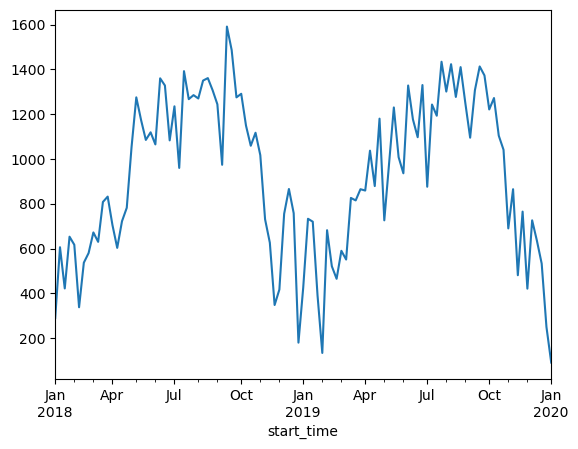

In [12]:
semanal.plot()

ONE STEP PREDICTION

In [13]:
from datetime import datetime

# Fechas en formato string
train_start_date = '2018-01-01'
train_end_date = '2019-06-01'
test_start_date = '2019-06-01'
test_end_date = '2019-12-31'

# Convertir las fechas al formato datetime
train_start_date = datetime.strptime(train_start_date, '%Y-%m-%d')
train_end_date = datetime.strptime(train_end_date, '%Y-%m-%d')
test_start_date = datetime.strptime(test_start_date, '%Y-%m-%d')
test_end_date = datetime.strptime(test_end_date, '%Y-%m-%d')

# Calcular la diferencia en semanas para el conjunto de entrenamiento
diferencia_semanas_train = (train_end_date - train_start_date).days // 7

# Calcular la diferencia en semanas para el conjunto de prueba
diferencia_semanas_test = (test_end_date - test_start_date).days // 7

# Imprimir los resultados
print("Diferencia en semanas para entrenamiento:", diferencia_semanas_train)
print("Diferencia en semanas para prueba:", diferencia_semanas_test)



Diferencia en semanas para entrenamiento: 73
Diferencia en semanas para prueba: 30


In [14]:
#Creamos los X e y con ceros para luego llenar con los datos. Notar los shape
look_back = 6
N = semanal.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(98, 6) (98,)


In [15]:
#rellenamos x e y
for i in range(X.shape[0]):
    X[i,:] = semanal.iloc[i:i+look_back]
    y[i] = semanal.iloc[i+look_back]

In [16]:
#Hacemos el train/test split.
N_train = 74 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 30 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(68, 6) (68,)
(30, 6) (30,)


In [17]:
# Crear una instancia del modelo RandomForestRegressor
modelo_rf = RandomForestRegressor(n_estimators=500, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
modelo_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [18]:
# Hacer predicciones en el conjunto de prueba
y_test_pred = modelo_rf.predict(X_test)
# Hacer predicciones en el conjunto de entrenamiento
y_train_pred = modelo_rf.predict(X_train)

In [19]:
# Calcular el error de entrenamiento (MSE y RMSE)
MSE_train = mean_squared_error(y_train, y_train_pred)
RMSE_train = np.sqrt(MSE_train)
print("Mean Squared Error (MSE) en Train:", MSE_train)
print("Root Mean Squared Error (RMSE) en Train:", RMSE_train)

# Calcular el error de prueba (MSE y RMSE)
MSE_test = mean_squared_error(y_test, y_test_pred)
RMSE_test = np.sqrt(MSE_test)
print("Mean Squared Error (MSE) en Test:", MSE_test)
print("Root Mean Squared Error (RMSE) en Test:", RMSE_test)

Mean Squared Error (MSE) en Train: 5756.795006882353
Root Mean Squared Error (RMSE) en Train: 75.87354615992555
Mean Squared Error (MSE) en Test: 41033.5071252
Root Mean Squared Error (RMSE) en Test: 202.56729036347403


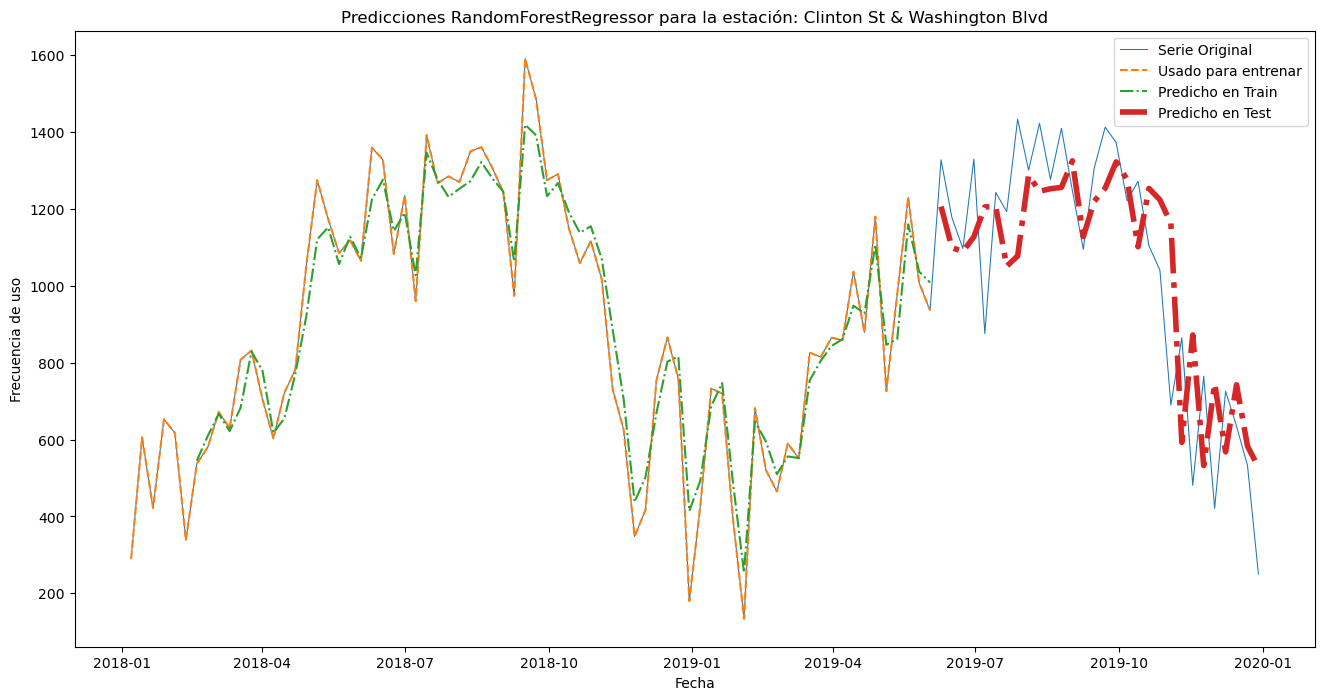

In [20]:
plt.figure(figsize=(16,8))
plt.plot(semanal.index[:length_total], semanal[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(semanal.index[:N_train + look_back], semanal[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(semanal.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(semanal.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de uso')
plt.title('Predicciones RandomForestRegressor para la estación: ' + estacion_elegida)
plt.show()

In [21]:
#Utilizamos un benchmark
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

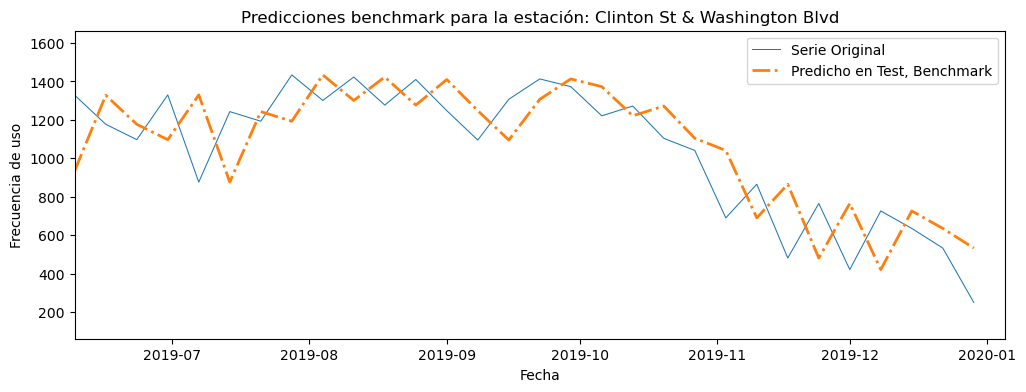

In [22]:
plt.figure(figsize=(12,4))
plt.plot(semanal.index[:length_total], semanal[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(semanal.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(semanal.index[N_train+look_back], semanal.index[length_total])
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de uso')
plt.legend()
plt.title('Predicciones benchmark para la estación: ' + estacion_elegida)
plt.show()

In [23]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

228.58419309596482


In [24]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Definir el modelo XGBoost
model = xgb.XGBRegressor()

# Definir los hiperparámetros a ajustar en la búsqueda
param_search = {'max_depth': [3, 5]}

# Definir la estrategia de validación cruzada para series de tiempo (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=3)

# Realizar la búsqueda en cuadrícula con GridSearchCV
gsearch = GridSearchCV(estimator=model, cv=tscv, scoring='neg_mean_squared_error', param_grid=param_search)

# Entrenar el modelo con la búsqueda en cuadrícula utilizando los datos de entrenamiento
gsearch.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados por GridSearchCV
best_max_depth = gsearch.best_params_['max_depth']

# Crear una nueva instancia del modelo XGBoost con los mejores hiperparámetros
best_model = xgb.XGBRegressor(max_depth=best_max_depth)

# Entrenar el modelo con los mejores hiperparámetros utilizando los datos de entrenamiento completos
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_test = best_model.predict(X_test)

# Calcular el RMSE en el conjunto de prueba
from sklearn.metrics import mean_squared_error
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Root Mean Squared Error (RMSE) en Test con mejores hiperparámetros:", rmse_test)


Root Mean Squared Error (RMSE) en Test con mejores hiperparámetros: 231.8608226453507


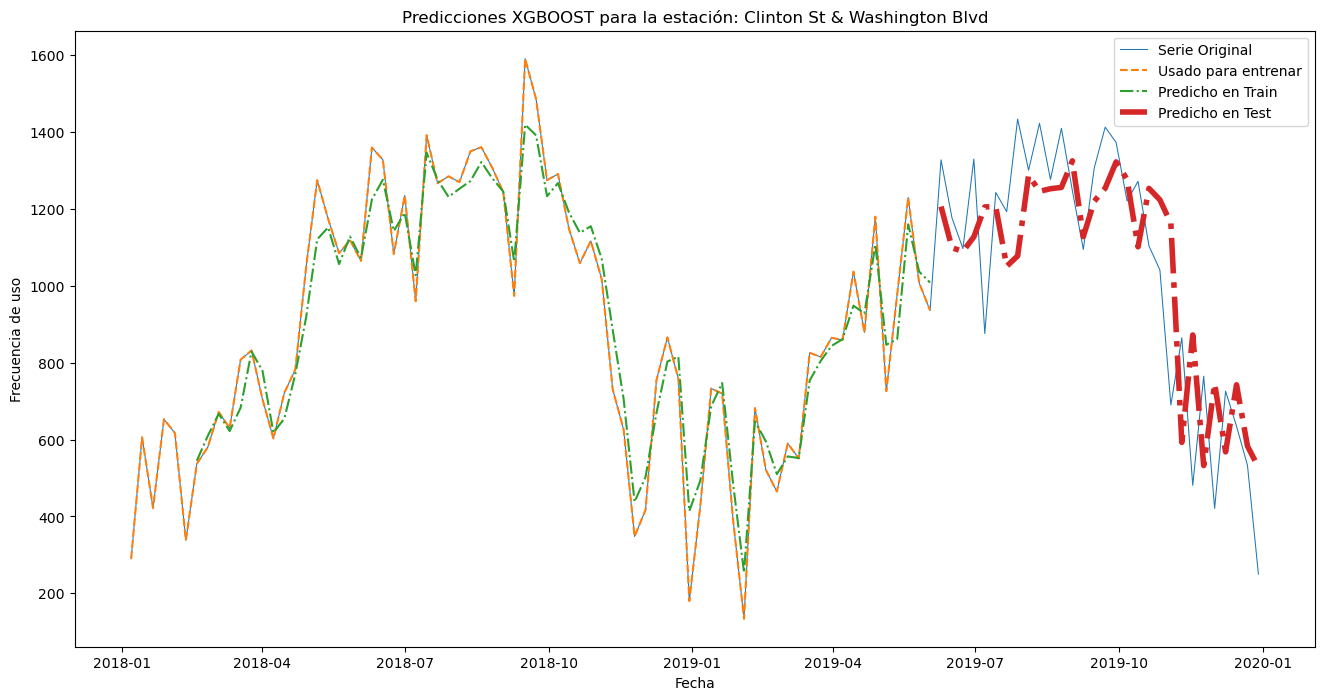

In [25]:
# Graficar la serie original
plt.figure(figsize=(16, 8))
plt.plot(semanal.index[:length_total], semanal[:length_total], lw=0.75, label='Serie Original')

# Graficar los datos utilizados para entrenar
plt.plot(semanal.index[:N_train + look_back], semanal[:N_train + look_back], '--', label='Usado para entrenar')

# Graficar las predicciones en el conjunto de entrenamiento
plt.plot(semanal.index[look_back: look_back + N_train], y_train_pred, '-.', label='Predicho en Train')

# Graficar las predicciones en el conjunto de prueba
plt.plot(semanal.index[N_train + look_back: length_total], y_test_pred, '-.', lw=4, label='Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de uso')
plt.title('Predicciones XGBOOST para la estación: ' + estacion_elegida)
plt.show()


SARIMA

In [26]:
#Separar entre Train y Test
train_data = semanal['2018-01-01':'2019-06-01']
test_data = semanal['2019-06-01':'2019-12-31']

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ajustar el modelo SARIMA
modelo_sarima = SARIMAX(train_data,
                        order=(1, 1, 1),                  # Parámetros (p, d, q) del componente ARIMA
                        seasonal_order=(3, 1, 1, 12),     # Parámetros (P, D, Q, S) del componente estacional
                        enforce_stationarity=False,      # No forzar estacionariedad
                        enforce_invertibility=False)     # No forzar invertibilidad


In [28]:
# Ajustar el modelo a los datos de entrenamiento
resultado = modelo_sarima.fit()

# Realizar predicciones en el conjunto de prueba
y_pred = resultado.predict(start='2019-06-01', end='2019-12-31')
# Asegurar que las fechas de las predicciones coincidan con el conjunto de prueba
y_pred = y_pred[test_data.index]


In [29]:
# Calcular el error de predicción (RMSE) en el conjunto de prueba
rmse = mean_squared_error(test_data, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) en Test:", rmse)

Root Mean Squared Error (RMSE) en Test: 266.9020133516325


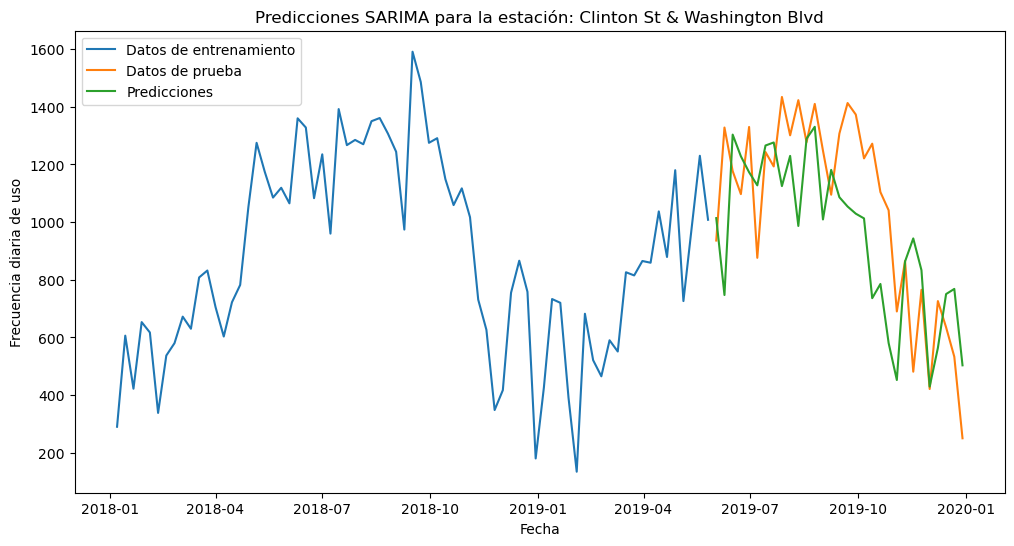

In [30]:
# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, label='Datos de entrenamiento')
plt.plot(test_data.index, test_data.values, label='Datos de prueba')
plt.plot(y_pred.index, y_pred.values, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia diaria de uso')
plt.title('Predicciones SARIMA para la estación: ' + estacion_elegida)
plt.legend()
plt.show()

# MEJOR ESTACIONES DE CONSUMIDORES

In [31]:
#Elegir la estación deseada
estacion_elegida_c = 'Streeter Dr & Grand Ave'  # Reemplaza 'Nombre de la estación' por el nombre real de la estación.

#Filtrar los datos para la estación deseada.
data_estacion_elegida_c = data[data['from_station_name'] == estacion_elegida_c].copy()

In [32]:
#Convertir la columna 'start_time' en formato datetime y establecerla como índice.
data_estacion_elegida_c['start_time'] = pd.to_datetime(data_estacion_elegida_c['start_time'])
data_estacion_elegida_c.set_index('start_time', inplace=True)

In [33]:
#Agrupar por día y contar la frecuencia de registros.
frecuencia_por_dia_c = data_estacion_elegida_c.resample('D').size()
frecuencia_por_dia_c

start_time
2018-01-01      1
2018-01-02      3
2018-01-03      3
2018-01-04      3
2018-01-05      3
             ... 
2019-12-27     67
2019-12-28     29
2019-12-29    100
2019-12-30     27
2019-12-31      6
Freq: D, Length: 730, dtype: int64

In [34]:
semanal_c = frecuencia_por_dia_c.resample('W').sum()
semanal_c.head()

start_time
2018-01-07     25
2018-01-14     66
2018-01-21     98
2018-01-28    222
2018-02-04     56
Freq: W-SUN, dtype: int64

<AxesSubplot:xlabel='start_time'>

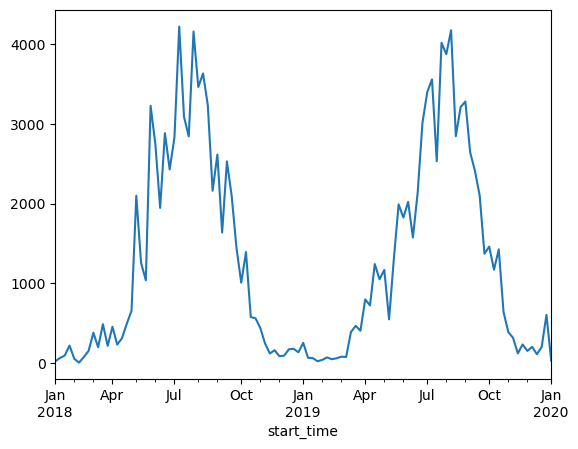

In [35]:
semanal_c.plot()

ONE STEP PREDICTION

In [36]:
from datetime import datetime

# Fechas en formato string
train_start_date = '2018-01-01'
train_end_date = '2019-06-01'
test_start_date = '2019-06-01'
test_end_date = '2019-12-31'

# Convertir las fechas al formato datetime
train_start_date = datetime.strptime(train_start_date, '%Y-%m-%d')
train_end_date = datetime.strptime(train_end_date, '%Y-%m-%d')
test_start_date = datetime.strptime(test_start_date, '%Y-%m-%d')
test_end_date = datetime.strptime(test_end_date, '%Y-%m-%d')

# Calcular la diferencia en semanas para el conjunto de entrenamiento
diferencia_semanas_train = (train_end_date - train_start_date).days // 7

# Calcular la diferencia en semanas para el conjunto de prueba
diferencia_semanas_test = (test_end_date - test_start_date).days // 7

# Imprimir los resultados
print("Diferencia en semanas para entrenamiento:", diferencia_semanas_train)
print("Diferencia en semanas para prueba:", diferencia_semanas_test)


Diferencia en semanas para entrenamiento: 73
Diferencia en semanas para prueba: 30


In [37]:
look_back = 6
N_c = semanal.shape[0]
X_c = np.zeros((N_c - look_back - 1,look_back))
y_c = np.zeros(N_c - look_back - 1)
print(X_c.shape, y_c.shape)

for i in range(X.shape[0]):
    X_c[i,:] = semanal_c.iloc[i:i+look_back]
    y_c[i] = semanal_c.iloc[i+look_back]

(98, 6) (98,)


In [38]:
N_train_c = 74 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test_c = 30 #cantidad de puntos que vamos a usar para evaluar
N_total_c = N_train_c + N_test_c

length_total_c = N_train_c + N_test_c + + look_back

X_train_c = X_c[:N_train_c,:]
y_train_c = y_c[:N_train_c]
print(X_train_c.shape, y_train_c.shape)

X_test_c = X_c[N_train_c:N_train_c+N_test_c,:]
y_test_c = y_c[N_train_c:N_train_c+N_test_c]
print(X_test_c.shape, y_test_c.shape)

(68, 6) (68,)
(30, 6) (30,)


In [39]:
# Crear una instancia del modelo RandomForestRegressor
modelo_rf_c = RandomForestRegressor(n_estimators=500, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
modelo_rf_c.fit(X_train_c, y_train_c)

RandomForestRegressor(n_estimators=500, random_state=42)

In [40]:
# Hacer predicciones en el conjunto de entrenamiento y prueba para los consumidores
y_train_pred_c = modelo_rf_c.predict(X_train_c)
y_test_pred_c = modelo_rf_c.predict(X_test_c)

In [41]:
# Calcular el error de entrenamiento (MSE y RMSE)
MSE_train_c = mean_squared_error(y_train_c, y_train_pred_c)
RMSE_train_c = np.sqrt(MSE_train_c)
print("Mean Squared Error (MSE) en Train:", MSE_train_c)
print("Root Mean Squared Error (RMSE) en Train:", RMSE_train_c)

# Calcular el error de prueba (MSE y RMSE)
MSE_test_c = mean_squared_error(y_test_c, y_test_pred_c)
RMSE_test_c = np.sqrt(MSE_test_c)
print("Mean Squared Error (MSE) en Test:", MSE_test_c)
print("Root Mean Squared Error (RMSE) en Test:", RMSE_test_c)

Mean Squared Error (MSE) en Train: 58491.88050388236
Root Mean Squared Error (RMSE) en Train: 241.85094687406615
Mean Squared Error (MSE) en Test: 321537.4592911999
Root Mean Squared Error (RMSE) en Test: 567.042731450814


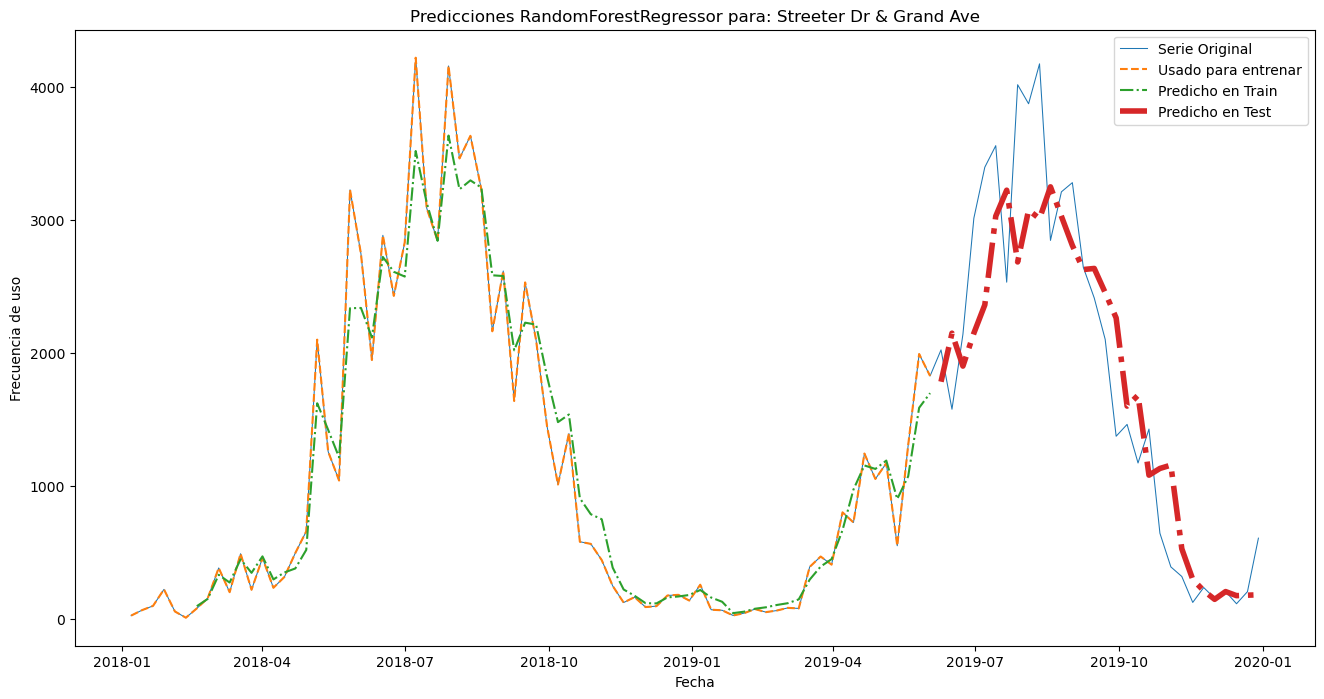

In [42]:
plt.figure(figsize=(16,8))
plt.plot(semanal_c.index[:length_total_c], semanal_c[:length_total_c],lw = 0.75, label = 'Serie Original')
plt.plot(semanal_c.index[:N_train_c + look_back], semanal_c[:N_train_c + look_back],'--', label = 'Usado para entrenar')
plt.plot(semanal_c.index[look_back: look_back + N_train_c], y_train_pred_c,'-.',label = 'Predicho en Train')
plt.plot(semanal_c.index[N_train_c+look_back: length_total_c], y_test_pred_c,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de uso')
plt.title('Predicciones RandomForestRegressor para: ' + estacion_elegida_c)
plt.show()


In [43]:
y_test_pred_benchmark_c = y[-1 + N_train_c:N_train_c+N_test_c - 1]

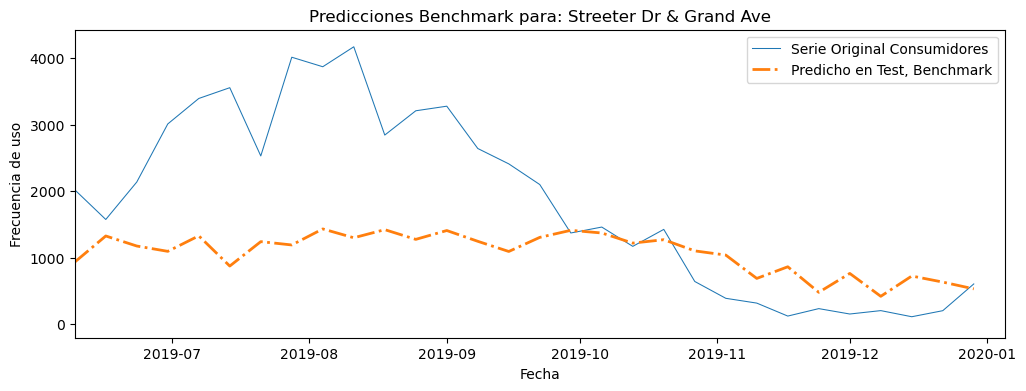

In [44]:
plt.figure(figsize=(12,4))
plt.plot(semanal_c.index[:length_total_c], semanal_c[:length_total],lw = 0.75, label = 'Serie Original Consumidores')
plt.plot(semanal_c.index[N_train_c+look_back: length_total_c], y_test_pred_benchmark_c,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(semanal_c.index[N_train_c+look_back], semanal_c.index[length_total])
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de uso')
plt.legend()
plt.title('Predicciones Benchmark para: ' + estacion_elegida_c)
plt.show()

In [45]:
MSE = mean_squared_error(y_test_c, y[-1 + N_train_c:N_train_c+N_test_c - 1])
print(np.sqrt(MSE))

1379.0986307488429


In [46]:
# Definir el modelo XGBoost
model_c = xgb.XGBRegressor()

# Definir los hiperparámetros a ajustar en la búsqueda
param_search = {'max_depth': [3, 5]}

# Definir la estrategia de validación cruzada para series de tiempo (TimeSeriesSplit)
tscv_c = TimeSeriesSplit(n_splits=3)

# Realizar la búsqueda en cuadrícula con GridSearchCV
gsearch_c = GridSearchCV(estimator=model, cv=tscv_c, scoring='neg_mean_squared_error', param_grid=param_search)

# Entrenar el modelo con la búsqueda en cuadrícula utilizando los datos de entrenamiento
gsearch_c.fit(X_train_c, y_train_c)

# Obtener los mejores hiperparámetros encontrados por GridSearchCV
best_max_depth_c = gsearch_c.best_params_['max_depth']

# Crear una nueva instancia del modelo XGBoost con los mejores hiperparámetros
best_model_c = xgb.XGBRegressor(max_depth=best_max_depth)

# Entrenar el modelo con los mejores hiperparámetros utilizando los datos de entrenamiento completos
best_model_c.fit(X_train_c, y_train_c)

# Hacer predicciones en el conjunto de prueba
y_pred_test_c = best_model_c.predict(X_test)

# Calcular el RMSE en el conjunto de prueba
from sklearn.metrics import mean_squared_error
rmse_test_c = np.sqrt(mean_squared_error(y_test_c, y_pred_test_c))
print("Root Mean Squared Error (RMSE) en Test con mejores hiperparámetros:", rmse_test_c)

Root Mean Squared Error (RMSE) en Test con mejores hiperparámetros: 1459.506196533914


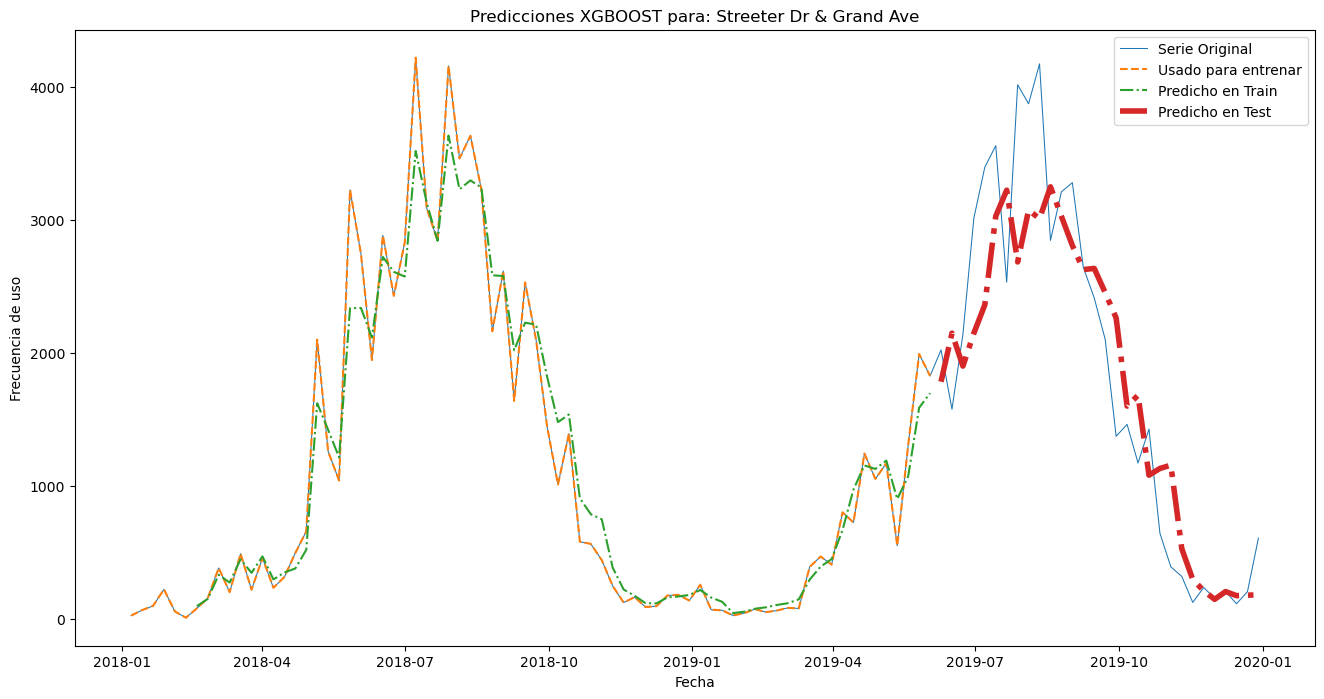

In [47]:
# Graficar la serie original
plt.figure(figsize=(16, 8))
plt.plot(semanal_c.index[:length_total_c], semanal_c[:length_total_c], lw=0.75, label='Serie Original')

# Graficar los datos utilizados para entrenar
plt.plot(semanal_c.index[:N_train_c + look_back], semanal_c[:N_train_c + look_back], '--', label='Usado para entrenar')

# Graficar las predicciones en el conjunto de entrenamiento
plt.plot(semanal_c.index[look_back: look_back + N_train_c], y_train_pred_c, '-.', label='Predicho en Train')

# Graficar las predicciones en el conjunto de prueba
plt.plot(semanal_c.index[N_train_c + look_back: length_total_c], y_test_pred_c, '-.', lw=4, label='Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de uso')
plt.title('Predicciones XGBOOST para: ' + estacion_elegida_c)
plt.show()


SARIMA

In [48]:
train_data_c = semanal['2018-01-01':'2019-06-01']
test_data_c = semanal['2019-06-01':'2019-12-31']

In [49]:
# Ajustar el modelo SARIMA
modelo_sarima_c = SARIMAX(train_data_c,
                        order=(1, 1, 1),                  # Parámetros (p, d, q) del componente ARIMA
                        seasonal_order=(3, 1, 1, 12),     # Parámetros (P, D, Q, S) del componente estacional
                        enforce_stationarity=False,      # No forzar estacionariedad
                        enforce_invertibility=False)     # No forzar invertibilidad
# Ajustar el modelo a los datos de entrenamiento
resultado_c = modelo_sarima_c.fit()

# Realizar predicciones en el conjunto de prueba
y_pred_c = resultado_c.predict(start='2019-06-01', end='2019-12-31')
# Asegurar que las fechas de las predicciones coincidan con el conjunto de prueba
y_pred_c = y_pred_c[test_data_c.index]

# Calcular el error de predicción (RMSE) en el conjunto de prueba
rmse_c = mean_squared_error(test_data_c, y_pred_c, squared=False)
print("Root Mean Squared Error (RMSE) en Test:", rmse_c)

Root Mean Squared Error (RMSE) en Test: 266.9020133516325


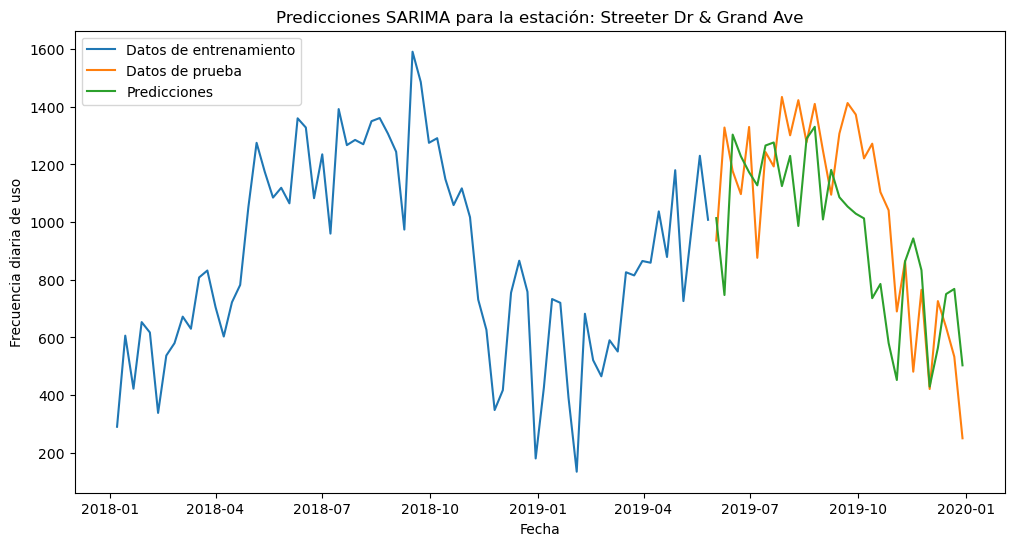

In [50]:
# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data_c.index, train_data_c.values, label='Datos de entrenamiento')
plt.plot(test_data_c.index, test_data_c.values, label='Datos de prueba')
plt.plot(y_pred_c.index, y_pred_c.values, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia diaria de uso')
plt.title('Predicciones SARIMA para la estación: ' + estacion_elegida_c)
plt.legend()
plt.show()

# CONCLUSIONES